<a href="https://colab.research.google.com/github/Ayanlola2002/DATA-SCIENCE-PROJECTS/blob/master/app_download_tunde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

Saving app_download.csv to app_download.csv


{'app_download.csv': b'1,ABOVE_THE_FOLD,522594.0,GOOGLE_ADX,69,SM-A530F,0,0,0,BANNER_AND_VIDEO,-1,90,Samsung\n1,ABOVE_THE_FOLD,522594.0,GOOGLE_ADX,69,SM-A530F,0,0,0,BANNER_AND_VIDEO,-1,90,Samsung\n1,POSITION_UNKNOWN,4560349.0,RUBICON,69,SM-J327T,0,1,1,VIDEO,-1,0,Samsung\n1,ABOVE_THE_FOLD,1486910.0,GOOGLE_ADX,69,Q3551,0,0,0,BANNER_AND_VIDEO,-1,90,Micromax\n1,ABOVE_THE_FOLD,1486910.0,GOOGLE_ADX,69,Q3551,0,0,0,BANNER_AND_VIDEO,-1,90,Micromax\n1,ABOVE_THE_FOLD,1486910.0,GOOGLE_ADX,69,Q3551,0,0,0,BANNER_AND_VIDEO,-1,90,Micromax\n1,,,MOPUB,69,SM-J327A,0,0,0,NATIVE,-1,1940,Samsung\n1,,,MOPUB,69,SM-J327A,0,0,0,NATIVE,-1,1940,Samsung\n1,,4560349.0,OPENX,69,MP450,0,0,0,VIDEO,-1,0,LG\n1,,4560349.0,OPENX,69,MP450,0,0,0,VIDEO,-1,0,LG\n1,POSITION_UNKNOWN,4951788.0,RUBICON,69,Z557BL,0,1,1,VIDEO,-1,0,ZTE\n1,POSITION_UNKNOWN,4951788.0,RUBICON,69,Z557BL,0,1,1,VIDEO,-1,0,ZTE\n1,,4633419.0,PULSEPOINT,69,UL40,0,1,1,VIDEO,-1,0,-1\n1,,4633419.0,PULSEPOINT,69,UL40,0,1,1,VIDEO,-1,0,-1\n1,ABOVE_THE_FOLD,551487.

In [0]:
!pip install rfpimp

  Running setup.py bdist_wheel for rfpimp ... - done
  Stored in directory: /root/.cache/pip/wheels/89/b6/b5/feff4a3b6d4307f12a249bedf676f94ea1eb31b59d1aa95ccd
  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built rfpimp sklearn


In [0]:
!pip install missingno

In [0]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from rfpimp import feature_corr_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,RandomizedSearchCV
)
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [0]:
data = pd.read_csv("app_download.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15047 entries, 0 to 15046
Data columns (total 13 columns):
1                   15047 non-null int64
ABOVE_THE_FOLD      8923 non-null object
522594.0            13627 non-null float64
GOOGLE_ADX          15047 non-null object
69                  15047 non-null object
SM-A530F            15047 non-null object
0                   15047 non-null int64
0.1                 15047 non-null int64
0.2                 15047 non-null int64
BANNER_AND_VIDEO    15047 non-null object
-1                  15047 non-null int64
90                  15047 non-null int64
Samsung             15047 non-null object
dtypes: float64(1), int64(6), object(6)
memory usage: 1.5+ MB


In [0]:
data.columns = ['conversions_r', 'ad_position', 'geo_city', 'inventory_source', 'platform_browser_version',	'platform_device_model', 'video_companion_required',	'video_completes',	'video_midpoints',	'placement_type',	'banner_width',	'bid_floor_micros',	'platform_device_make']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15047 entries, 0 to 15046
Data columns (total 13 columns):
conversions_r               15047 non-null int64
ad_position                 8923 non-null object
geo_city                    13627 non-null float64
inventory_source            15047 non-null object
platform_browser_version    15047 non-null object
platform_device_model       15047 non-null object
video_companion_required    15047 non-null int64
video_completes             15047 non-null int64
video_midpoints             15047 non-null int64
placement_type              15047 non-null object
banner_width                15047 non-null int64
bid_floor_micros            15047 non-null int64
platform_device_make        15047 non-null object
dtypes: float64(1), int64(6), object(6)
memory usage: 1.5+ MB


In [0]:
def df_datatypes(dataframe):
    print(dataframe.columns.to_series().groupby(dataframe.dtypes).groups)
    
    df_datatypes(data)

In [0]:
def missing(dataframe, graph=False):
    dataframe_na = (dataframe.isnull().sum() / len(dataframe)) * 100
    dataframe_na = dataframe_na.drop(dataframe_na[dataframe_na == 0].index).sort_values(
        ascending=False
    )[:30]
    missing_data = pd.DataFrame({"Missing Ratio": dataframe_na})
    print(missing_data.head(20))
    if graph == True:
        missing_data = dataframe.columns[dataframe.isnull().any()].tolist()
        msno.matrix(dataframe[missing_data])
        msno.heatmap(dataframe[missing_data], figsize=(20, 20))
        
def cardinality(dataframe, datatype):
    d = []
    columns = dataframe.dtypes[dataframe.dtypes == datatype].index
    # columns = dataframe.columns.tolist()
    for c in columns:
        data = dataframe[c].nunique()
        d.append({"Column": c, "UniqueValue": data})
    df = pd.DataFrame(d).sort_values(ascending=False, by="UniqueValue")
    print(df)

    
def define_vars(dataframe, card_thresh):
    dtypes = dataframe.dtypes
    cat_feats = dataframe.dtypes[dataframe.dtypes == "object"].index
    numeric_feats = dataframe.dtypes[dataframe.dtypes != "object"].index
    col_nunique = dict()
    for col in numeric_feats:
        col_nunique[col] = dataframe[col].nunique()
    col_nunique = pd.Series(col_nunique)
    cols_discrete = col_nunique[col_nunique < card_thresh].index.tolist()
    cols_continuous = col_nunique[col_nunique >= card_thresh].index.tolist()
    return cols_discrete, cols_continuous, cat_feats

def PlotCont(dataframe, columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3 * fcols, 4 * frows))
    i = 0
    for col in columns:
        i += 1
        ax = plt.subplot(frows, fcols, i)
        sns.distplot(dataframe[col], ax=ax)
    plt.xlabel(col)
    
def PlotCat(dataframe, cat_feats, fcols=3):
    fcols = fcols
    frows = ceil(len(cat_feats) / fcols)
    plt.figure(figsize=(20, frows * 4))

    for i, col in enumerate(cat_feats):
        plt.subplot(frows, fcols, i + 1)
        sns.countplot(dataframe[col])
        

def PlotCatRegress(dataframe,target,cat_feats,fcols=3):
    fcols = 3
    frows = ceil(len(cat_feats)/fcols)
    plt.figure(figsize = (20,frows*4))
    
    for i,col in enumerate(cat_feats):
        plt.subplot(frows,fcols,i+1)
        sns.violinplot(dataframe[col],dataframe[target],inner="stick")

# plots all continuous variables vs target


def PlotContRegress(dataframe,target,columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3*fcols,4*frows))
    i=0
    for col in columns:
        i+=1
        ax=plt.subplot(frows,fcols,i)
        sns.regplot(x=col,y=target,data=dataframe,ax=ax)
    plt.xlabel(col)

def pear_corr(dataframe):
    df_corr_mat = feature_corr_matrix(dataframe)
    df_corr_mat = df_corr_mat.dropna(axis='columns',how='all')
    df_corr_mat = df_corr_mat.dropna()
    df_corr_mat = df_corr_mat.values
    corr_condensed = hc.distance.squareform(1-df_corr_mat)
    z = hc.linkage(corr_condensed,method='average')
    fig = plt.figure(figsize=(20,10))
    dendrogram = hc.dendrogram(z,labels=dataframe.columns,orientation = 'left',leaf_font_size = 8)

In [0]:
missing(data)

             Missing Ratio
ad_position      40.699143
geo_city          9.437097


In [0]:
print(cardinality(data,datatype= 'int64'))
print(cardinality(data,datatype= 'float64'))
print(cardinality(data,datatype= 'object'))

                     Column  UniqueValue
5          bid_floor_micros          197
4              banner_width            8
0             conversions_r            2
1  video_companion_required            2
2           video_completes            2
3           video_midpoints            2
None
     Column  UniqueValue
0  geo_city         2873
None
                     Column  UniqueValue
3     platform_device_model         1571
5      platform_device_make          111
2  platform_browser_version           36
1          inventory_source           14
4            placement_type            5
0               ad_position            4
None


In [0]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

col_0,% observations
ad_position,
0,0.023535
ABOVE_THE_FOLD,0.687997
FULLSCREEN,0.007845
POSITION_UNKNOWN,0.280623


col_0,% observations
inventory_source,
AERSERV,0.009171
APP_LOVIN,0.003190
FYBER,0.004918
GOOGLE_ADX,0.362996
MILLENNIAL,0.001529
MOPUB,0.123812
OPENX,0.024058
OPERA_MEDIA,0.012029
PULSEPOINT,0.108394


col_0,% observations
platform_browser_version,
-1,0.146209
11,0.000266
30,0.012428
33,0.004984
37,0.000665
39,0.002193
4,0.007510
40,0.001196
43,0.002193


col_0,% observations
platform_device_model,
-1,0.016016
0PKX220,0.000399
0PM92,0.000133
1606,0.000332
1707,0.000199
1718,0.000133
1801,0.000266
2,0.000665
2 Lite,0.000199


col_0,% observations
placement_type,
BANNER,0.168472
BANNER_AND_VIDEO,0.195919
NATIVE,0.072174
UNKNOWN,0.013956
VIDEO,0.549478


col_0,% observations
platform_device_make,
-1,0.021067
4Good,0.000133
Acer,0.000199
Alcatel,0.015418
Aolixin,0.000066
Apple,0.138699
Archos,0.000066
Ark,0.000066
Asus,0.012627


,conversions_r,geo_city,video_companion_required,video_completes,video_midpoints,banner_width,bid_floor_micros
count,15047.000000,1.362700e+04,15047.000000,15047.000000,15047.000000,15047.000000,15047.000000
mean,0.335416,3.378730e+06,0.215259,0.406260,0.498771,61.074899,254.800359
std,0.472151,2.060906e+06,0.411015,0.491151,0.500015,131.273919,660.981708
min,0.000000,-1.000000e+00,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.000000,5.548400e+05,0.000000,0.000000,0.000000,-1.000000,0.000000
50%,0.000000,4.360321e+06,0.000000,0.000000,0.000000,-1.000000,10.000000
75%,1.000000,4.990729e+06,0.000000,1.000000,1.000000,-1.000000,90.000000
max,1.000000,1.179039e+07,1.000000,1.000000,1.000000,1024.000000,5430.000000


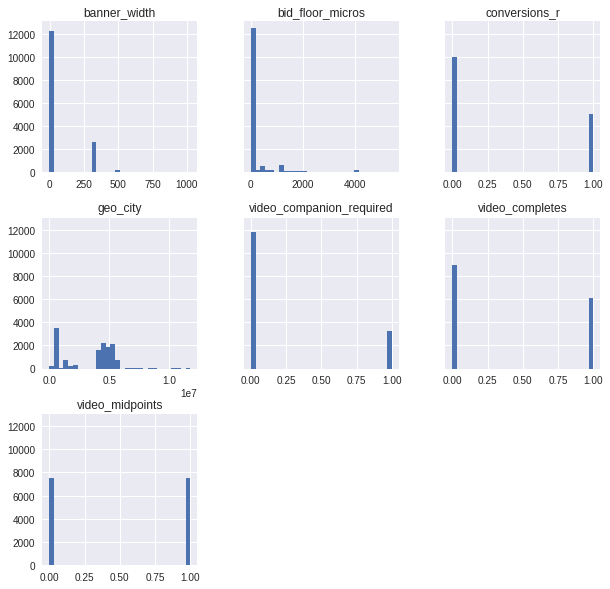

In [0]:
# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

In [0]:
discrete,cont,cat = define_vars(data,1)
import matplotlib.pyplot as plt 
import seaborn as sns




for column in data.select_dtypes(include=['object']).columns:
    if column != 'conversions_r':
        display(pd.crosstab(index=data[column], columns=data['conversions_r'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'conversions_r']].hist(by="conversions_r", bins=30)
    plt.show()

conversions_r,0,1
ad_position,,
0,0.026526,0.018067
ABOVE_THE_FOLD,0.766470,0.544532
FULLSCREEN,0.003988,0.014897
POSITION_UNKNOWN,0.203017,0.422504


conversions_r,0,1
inventory_source,,
AERSERV,0.0069,0.013671
APP_LOVIN,0.0018,0.005944
FYBER,0.0024,0.009907
GOOGLE_ADX,0.4114,0.267089
MILLENNIAL,0.0023,0.000000
MOPUB,0.1212,0.128988
OPENX,0.0230,0.026154
OPERA_MEDIA,0.0093,0.017436
PULSEPOINT,0.0897,0.145433


conversions_r,0,1
platform_browser_version,,
-1,0.1599,0.119081
11,0.0004,0.000000
30,0.0157,0.005944
33,0.0058,0.003368
37,0.0010,0.000000
39,0.0030,0.000594
4,0.0101,0.002378
40,0.0012,0.001189
43,0.0027,0.001189


conversions_r,0,1
platform_device_model,,
-1,0.0166,0.014860
0PKX220,0.0004,0.000396
0PM92,0.0000,0.000396
1606,0.0002,0.000594
1707,0.0000,0.000594
1718,0.0002,0.000000
1801,0.0001,0.000594
2,0.0010,0.000000
2 Lite,0.0003,0.000000


conversions_r,0,1
placement_type,,
BANNER,0.2487,0.009511
BANNER_AND_VIDEO,0.1631,0.260947
NATIVE,0.0824,0.051912
UNKNOWN,0.0153,0.011294
VIDEO,0.4905,0.666336


conversions_r,0,1
platform_device_make,,
-1,0.0229,0.017436
4Good,0.0002,0.000000
Acer,0.0003,0.000000
Alcatel,0.0144,0.017436
Aolixin,0.0001,0.000000
Apple,0.1544,0.107589
Archos,0.0001,0.000000
Ark,0.0001,0.000000
Asus,0.0145,0.008916


conversions_r


ValueError: ignored

,conversions_r,geo_city,video_companion_required,video_completes,video_midpoints,banner_width,bid_floor_micros
conversions_r,1.000000,0.110172,-0.053568,0.273021,0.258074,-0.172216,0.115177
geo_city,0.110172,1.000000,0.326127,0.438635,0.545681,-0.462428,0.188337
video_companion_required,-0.053568,0.326127,1.000000,0.119223,0.267930,0.022907,-0.084285
video_completes,0.273021,0.438635,0.119223,1.000000,0.810551,-0.182595,0.204079
video_midpoints,0.258074,0.545681,0.267930,0.810551,1.000000,-0.260840,0.171180
banner_width,-0.172216,-0.462428,0.022907,-0.182595,-0.260840,1.000000,-0.054719
bid_floor_micros,0.115177,0.188337,-0.084285,0.204079,0.171180,-0.054719,1.000000


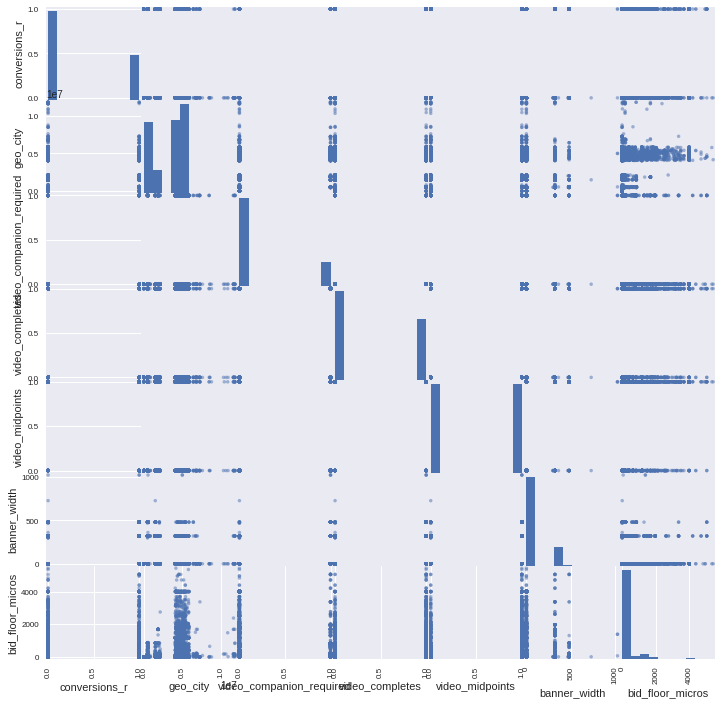

In [0]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


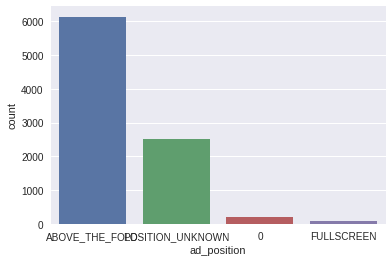

In [0]:
 ax = sns.countplot(x="ad_position", data=data) #hue="who",